# Introduction

This is a map-reduce version of expectation maximization algo for a mixture of Gaussians model. There are two mrJob MR packages, mr_GMixEmIterate and mr_GMixEmInitialize.  The driver calls the mrJob packages and manages the iteration. 

##E Step: Given priors, mean vector and covariance matrix, calculate the probability of that each data point belongs to a class 

![algo](http://i.stack.imgur.com/hMAUZ.png)

In [100]:
from IPython.display import display, Math, Latex
print ('Equation 1:')
display(Math(r'  p(w_k | x^{(i)},\theta) = \frac{\pi_k N(x^{(i)}|\mu_k, \Sigma_{k})}{(\sum_{j=1}^{K} \pi_j N(x^{(i)}|\mu_j, \Sigma_{j})}'))

Equation 1:


<IPython.core.display.Math object>

##M Step: Given probabilities, update priors, mean and covariance

![algo](http://i.stack.imgur.com/kvQup.png)

In [101]:
from IPython.display import display, Math, Latex
print ('Equation 2:')
display(Math(r'  \hat{\mu_k} = \frac{1}{n_k} \sum_{j=1}^{n}p(w_k | x^{(i)},\theta) x^{(i)}'))

Equation 2:


<IPython.core.display.Math object>

In [102]:
from IPython.display import display, Math, Latex
print ('Equation 3:')
display(Math(r'  \hat{\Sigma_k} = \frac{1}{n_k} \sum_{j=1}^{n}p(w_k | x^{(i)},\theta)(x^{(i)}-\hat{\mu_k})(x^{(i)}-\hat{\mu_k})^{T}'))

Equation 3:


<IPython.core.display.Math object>

In [103]:
from IPython.display import display, Math, Latex
print ('Equation 4:')
display(Math(r'  \hat{\pi_k} = \frac{n_k}{n} {\ } where {\ } {n_k} = \sum_{j=1}^{n}p(w_k | x^{(i)},\theta)'))

Equation 4:


<IPython.core.display.Math object>

#Data Generation

In [104]:
### Generate an input file based on multivariate normal distribution of 3 samples:
### Sample 1 has a mean of 4,0
### Sample 2 has a mean of 6,6
### Sample 3 has a mean of 0,4
### All of them have diagonal covariance


%matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
with open("data.txt", "w") as f:
    for row in data.tolist():
        json.dump(row, f)
        f.write("\n")

In [105]:
!head data.txt  ### Here find a sample of our input file

[5.881936065369871, 5.750545806687156]
[3.9815262118745016, 1.3264189052581978]
[-0.6688240474985631, 4.064487035023158]
[6.791586028240216, 5.648908834997144]
[6.362643104107701, 5.690583041718334]
[-1.3793659902086064, 2.8416583747159487]
[7.730283697390212, 4.894586950748419]
[6.632184023777138, 4.74407994680102]
[-0.5056355148320887, 4.943693164866562]
[2.9386208727359158, 0.6324585165194353]


# Data Visualiazation

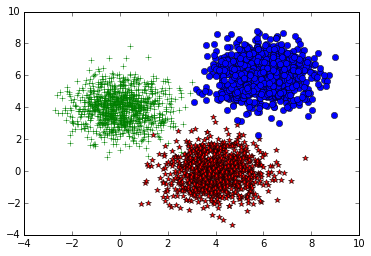

In [106]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

# Initialization

Here suppose we know there are 3 components

In [107]:
%%writefile mr_GMixEmInitialize.py
from mrjob.job import MRJob

from numpy import mat, zeros, shape, random, array, zeros_like, dot, linalg
from random import sample
import json
from math import pi, sqrt, exp, pow


class MrGMixEmInit(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEmInit, self).__init__(*args, **kwargs)
        
        self.numMappers = 1     #number of mappers
        self.count = 0
        
### Let's first define that we're looking for 3 clusters                                                 
    def configure_options(self):
        super(MrGMixEmInit, self).configure_options()
        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--', dest='', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, xjIn):
        #something simple to grab random starting point
        #collect the first 2k
        if self.count <= 2*self.options.k:
            self.count += 1
            yield (1,xjIn)        
        
    def reducer(self, key, xjIn):        
        #accumulate data points mapped to 0 from 1st mapper and pull out k of them as starting point
        cent = []
        for xj in xjIn:
            x = json.loads(xj)
            cent.append(x)
            yield 1, xj
        index = sample(range(len(cent)), self.options.k)
        cent2 = []
        for i in index:
            cent2.append(cent[i])
        
        
            
        #use the covariance of the selected centers as the starting guess for covariances
        #first, calculate mean of centers
        
        mu = array(cent2[0])
        for i in range(1,self.options.k):
            mu = mu + array(cent2[i])
        mu = mu/float(self.options.k)          #####  This initializes value for mu (equation 2)
        
       
        
        #then accumulate the deviations
        sigma = zeros((len(mu),len(mu)),dtype=float)
        for x in cent2:
            xmm = array(x) - mu
            for i in range(len(mu)):
                sigma[i,i] = sigma[i,i] + xmm[i]*xmm[i]   
                
        sigma = sigma/(float(self.options.k))  #### This initilizes value for sigma (equation 3)
        sigmaInv = linalg.inv(sigma)           ### This is the inverted sigma
        
        sigma_1 = [sigmaInv.tolist()]*self.options.k
        
        jDebug = json.dumps([cent2,mu.tolist(),sigma.tolist(),sigmaInv.tolist(),sigma_1])    
        debugPath = self.options.pathName + 'debug.txt'
        fileOut = open(debugPath,'w')
        fileOut.write(jDebug)
        fileOut.close()
        
        #also need a starting guess at the phi's - prior probabilities
        #initialize them all with the same number - 1/k - equally probably for each cluster
        
        phi = zeros(self.options.k,dtype=float)
        
        for i in range(self.options.k):
            phi[i] = 1.0/float(self.options.k)    ### Initializing priors to 1/3 (equation 4)
        
        #form output object
        outputList = [phi.tolist(), cent2, sigma_1]
            
        jsonOut  = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == '__main__':
    MrGMixEmInit.run()

Overwriting mr_GMixEmInitialize.py


# Iteration

**Mapper** – each mapper needs k vector means and covariance matrices to make probability calculations.  Can also accumulate partial sum (sum restricted to the mapper's input) of quantities required for update.  Then it emits partial sum as single output from combiner.  
    Emit (dummy_key, partial_sum_for_all_k's)

**Reducer** –the iterator pulls in the partial sum for all k's from all the mappers and combines in a single reducer.  In this case the reducer emits a single (json'd python object) with the new means and covariances.


In [116]:
%%writefile mr_GMixEmIterate.py
from mrjob.job import MRJob

from math import sqrt, exp, pow,pi
from numpy import zeros, shape, random, array, zeros_like, dot, linalg
import json

def gauss(x, mu, P_1):
    xtemp = x - mu
    n = len(x)
    p = exp(- 0.5*dot(xtemp,dot(P_1,xtemp)))
    detP = 1/linalg.det(P_1)
    p = p/(pow(2.0*pi,n/2.0)*sqrt(detP))
    return p

class MrGMixEm(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEm, self).__init__(*args, **kwargs)
        
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileIn = open(fullPath)
        inputJson = fileIn.read()
        fileIn.close()
        inputList = json.loads(inputJson)
        temp = inputList[0]        
        self.phi = array(temp)           #prior class probabilities
        temp = inputList[1]
        self.centroids = array(temp)         #current means list
        temp = inputList[2]
        self.sigma_1 = array(temp)         #inverse covariance matrices for w, calc.
        #accumulate partial sums                               
        #sum of weights - by cluster
        self.new_phi = zeros_like(self.phi)        #partial weighted sum of weights
        self.new_centroids = zeros_like(self.centroids)
        self.new_sigma = zeros_like(self.sigma_1)
        
        self.numMappers = 1             #number of mappers
        self.count = 0                  #passes through mapper
        
                                                 
    def configure_options(self):
        super(MrGMixEm, self).configure_options()

        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--', dest='', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, val):
        #accumulate partial sums for each mapper
        xList = json.loads(val)
        x = array(xList)
        wtVect = zeros_like(self.phi)
        for i in range(self.options.k):
            wtVect[i] = self.phi[i]*gauss(x,self.centroids[i],self.sigma_1[i])  ### Applying gaussian to guess of priors (equation 1)
        wtSum = sum(wtVect)
        wtVect = wtVect/wtSum
        #accumulate to update est of probability densities.
        #increment count
        self.count += 1
        #accumulate weights for phi est
        self.new_phi = self.new_phi + wtVect
        for i in range(self.options.k):
            #accumulate weighted x's for mean calc
            self.new_centroids[i] = self.new_centroids[i] + wtVect[i]*x
            #accumulate weighted squares for cov estimate
            xmm = x - self.centroids[i]
            covInc = zeros_like(self.new_sigma[i])
            
            for l in range(len(xmm)):
                for m in range(len(xmm)):
                    covInc[l][m] = xmm[l]*xmm[m]
            self.new_sigma[i] = self.new_sigma[i] + wtVect[i]*covInc     
        #dummy yield - real output passes to mapper_final in self

        
    def mapper_final(self):
        
        out = [self.count, (self.new_phi).tolist(), (self.new_centroids).tolist(), (self.new_sigma).tolist()]
        jOut = json.dumps(out)        
        
        yield 1,jOut
    
    
    def reducer(self, key, xs):
        #accumulate partial sums
        first = True        
        #accumulate partial sums
        #xs us a list of paritial stats, including count, phi, mean, and covariance. 
        #Each stats is k-length array, storing info for k components
        for val in xs:
            if first:
                temp = json.loads(val)
                #totCount, totPhi, totMeans, and totCov are all arrays
                totCount = temp[0]
                totPhi = array(temp[1])
                totCentroids = array(temp[2])
                totSigma = array(temp[3])                
                first = False
            else:
                temp = json.loads(val)
                #cumulative sum of four arrays
                totCount = totCount + temp[0]
                totPhi = totPhi + array(temp[1])
                totCentroids = totCentroids + array(temp[2])
                totSigma = totSigma + array(temp[3])
        #finish calculation of new probability parameters. array divided by array
        newPhi = totPhi/totCount
        #initialize these to something handy to get the right size arrays
        newCentroids = totCentroids
        newSigma_1 = totSigma
        for i in range(self.options.k):
            newCentroids[i,:] = totCentroids[i,:]/totPhi[i]
            tempSigma = totSigma[i,:,:]/totPhi[i]
            #almost done.  just need to invert the cov matrix.  invert here to save doing a matrix inversion
            #with every input data point.
            newSigma_1[i,:,:] = linalg.inv(tempCov)
        
        outputList = [newPhi.tolist(), newCentroids.tolist(), newSigma_1.tolist()]
        jsonOut = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == '__main__':
    MrGMixEm.run()

Overwriting mr_GMixEmIterate.py


# Driver

In [119]:
from mr_GMixEmInitialize import MrGMixEmInit
from mr_GMixEmIterate import MrGMixEm
import json
from math import sqrt

def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

def dist(x,y):
    #euclidean distance between two lists    
    sum = 0.0
    for i in range(len(x)):
        temp = x[i] - y[i]
        sum += temp * temp
    return sqrt(sum)

#first run the initializer to get starting centroids
filePath = 'data.txt'
mrJob = MrGMixEmInit(args=[filePath])
with mrJob.make_runner() as runner:
    runner.run()

#pull out the centroid values to compare with values after one iteration
emPath = "intermediateResults.txt"
fileIn = open(emPath)
paramJson = fileIn.read()
fileIn.close()

delta = 10
iter_num = 0
#Begin iteration on change in centroids
while delta > 0.02:
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1
    #parse old centroid values
    oldParam = json.loads(paramJson)
    #run one iteration
    oldMeans = oldParam[1]
    mrJob2 = MrGMixEm(args=[filePath])
    with mrJob2.make_runner() as runner:
        runner.run()

    #compare new centroids to old ones
    fileIn = open(emPath)
    paramJson = fileIn.read()
    fileIn.close()
    newParam = json.loads(paramJson)

    k_means = len(newParam[1])
    newMeans = newParam[1]

    delta = 0.0
    for i in range(k_means):
        delta += dist(newMeans[i],oldMeans[i])

    print oldMeans
    plot_iteration(oldMeans)
print "Iteration" + str(iter_num)
print newMeans
plot_iteration(newMeans)

Iteration0


AttributeError: 'MrGMixEm' object has no attribute 'mu'